# Homework - Classification

***Agata Makarewicz***

*Week 7*

## Introduction

Task: classification on Thyroid disease dataset

Thyroid disease dataset contains 3772 instances of medical records, including information such as age, sex, pregnancy, foregoing treatments, hormones levels and more, collected from patients of the Garavan Institute in Sydney, Australia. Our goal is to identify whether the patient has primary, secondary, or compensated hypothyroidism, or got a negative result (isn't ill) - this information is placed in the *Class* (target) variable.

In [2]:
# loading packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
# import datetime as dt 
import plotly.express as px

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer

from sklearn import metrics
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, confusion_matrix, f1_score, fbeta_score
from sklearn.metrics import matthews_corrcoef, plot_confusion_matrix, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC

import warnings
warnings.filterwarnings(action='ignore')
pd.options.display.max_columns = None

%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
data = pd.read_csv('dataset_57_hypothyroid.csv', na_values="?")
target = "Class"

## I EDA 

### I.I Basic exploration

In [4]:
data.head()

age sex on_thyroxine query_on_thyroxine on_antithyroid_medication sick  \
0  41.0   F            f                  f                         f    f   
1  23.0   F            f                  f                         f    f   
2  46.0   M            f                  f                         f    f   
3  70.0   F            t                  f                         f    f   
4  70.0   F            f                  f                         f    f   

  pregnant thyroid_surgery I131_treatment query_hypothyroid  \
0        f               f              f                 f   
1        f               f              f                 f   
2        f               f              f                 f   
3        f               f              f                 f   
4        f               f              f                 f   

  query_hyperthyroid lithium goitre tumor hypopituitary psych TSH_measured  \
0                  f       f      f     f             f     f            t   
1                  f       f      f     f             f     f            t   
2                  f       f      f     f             f     f            t   
3                  f       f      f     f             f     f            t   
4                  f       f      f     f             f     f            t   

    TSH T3_measured   T3 TT4_measured    TT4 T4U_measured   T4U FTI_measured  \
0  1.30           t  2.5            t  125.0            t  1.14            t   
1  4.10           t  2.0            t  102.0            f   NaN            f   
2  0.98           f  NaN            t  109.0            t  0.91            t   
3  0.16           t  1.9            t  175.0            f   NaN            f   
4  0.72           t  1.2            t   61.0            t  0.87            t   

     FTI TBG_measured  TBG referral_source     Class  
0  109.0            f  NaN            SVHC  negative  
1    NaN            f  NaN           other  negative  
2  120.0            f  NaN           other  negative  
3    NaN            f  NaN           other  negative  
4   70.0            f  NaN             SVI  negative

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        3771 non-null   float64
 1   sex                        3622 non-null   object 
 2   on_thyroxine               3772 non-null   object 
 3   query_on_thyroxine         3772 non-null   object 
 4   on_antithyroid_medication  3772 non-null   object 
 5   sick                       3772 non-null   object 
 6   pregnant                   3772 non-null   object 
 7   thyroid_surgery            3772 non-null   object 
 8   I131_treatment             3772 non-null   object 
 9   query_hypothyroid          3772 non-null   object 
 10  query_hyperthyroid         3772 non-null   object 
 11  lithium                    3772 non-null   object 
 12  goitre                     3772 non-null   object 
 13  tumor                      3772 non-null   objec

We can see that we have some features of type object with `_measuered` suffix and corresponding numerical features - they signalize whether the hormone level was tested, and if it was, a value is given. We can expect that those features (in pairs) will be highly correlated, as the `x` numerical columns contains `NaN` if the `x_measured` column contains `f`.

We can also observe one column filled with `NaN` so we will probably drop it later. There are also some missings in numerical variables, due to the fact described above. Also some missings in `age` and `sex` can be spotted. Fortunately, we have no missings in our target variable.

In [6]:
data.drop('TBG', axis=1).describe() # basic stats for numerical columns

age          TSH           T3          TT4          T4U  \
count  3771.000000  3403.000000  3003.000000  3541.000000  3385.000000   
mean     51.735879     5.086766     2.013500   108.319345     0.995000   
std      20.084958    24.521470     0.827434    35.604248     0.195457   
min       1.000000     0.005000     0.050000     2.000000     0.250000   
25%      36.000000     0.500000     1.600000    88.000000     0.880000   
50%      54.000000     1.400000     2.000000   103.000000     0.980000   
75%      67.000000     2.700000     2.400000   124.000000     1.080000   
max     455.000000   530.000000    10.600000   430.000000     2.320000   

               FTI  
count  3387.000000  
mean    110.469649  
std      33.089698  
min       2.000000  
25%      93.000000  
50%     107.000000  
75%     124.000000  
max     395.000000

Based on the statistics above, we can spot some anomalies - `age` equal to 455 is not possible value, also `TSH` hormone level at 530 and `TT4` on 430 look quite abnormal. In the Internet we can find cases with TSH level ~300, but it's hard to find higher than this. Let's check whether those patients were diagnosed with thyroid disease.

In [7]:
data.query('TSH > 400')

age  sex on_thyroxine query_on_thyroxine on_antithyroid_medication  \
1165  18.0    F            t                  f                         f   
2507   2.0  NaN            f                  f                         f   
2772  25.0    F            f                  f                         f   
3427  18.0    F            f                  f                         f   
3449  59.0    F            f                  f                         f   

     sick pregnant thyroid_surgery I131_treatment query_hypothyroid  \
1165    f        f               f              f                 f   
2507    f        f               f              f                 f   
2772    f        f               f              f                 f   
3427    f        f               f              f                 f   
3449    f        f               f              f                 f   

     query_hyperthyroid lithium goitre tumor hypopituitary psych TSH_measured  \
1165                  f       f      f     f             f     f            t   
2507                  f       f      f     f             f     f            t   
2772                  f       f      f     f             f     f            t   
3427                  f       f      f     f             f     f            t   
3449                  f       f      f     f             f     f            t   

        TSH T3_measured   T3 TT4_measured   TT4 T4U_measured   T4U  \
1165  478.0           f  NaN            t  45.0            t  1.30   
2507  472.0           t  1.7            t  34.0            t  1.17   
2772  468.0           t  0.7            t  21.0            t  1.10   
3427  440.0           t  0.5            t  24.0            t  1.32   
3449  530.0           t  2.0            t  10.0            t  1.12   

     FTI_measured   FTI TBG_measured  TBG referral_source                Class  
1165            t  34.0            f  NaN           other  primary_hypothyroid  
2507            t  29.0            f  NaN            STMW  primary_hypothyroid  
2772            t  19.0            f  NaN           other  primary_hypothyroid  
3427            t  18.0            f  NaN           other  primary_hypothyroid  
3449            t   8.5            f  NaN           other  primary_hypothyroid

It looks quite weird that such high level of `TSH` didn't resulted in more advanced hypothyroid than primary stage. However, given the medical nature of the data and no highest possible level of `TSH` defined (as well as the other hormones), we will leave those observations in the data.

### I.II Missing values

In [8]:
total = data.isna().sum().sort_values(ascending=False) # how many missings in each column
percent = (data.isna().sum()/data.isna().count()).round(4).sort_values(ascending=False) # in %
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).head(8) 
# selecting only 8 because from the data.info() we know how many columns have missings
missing_data

Total  Percent
TBG   3772   1.0000
T3     769   0.2039
T4U    387   0.1026
FTI    385   0.1021
TSH    369   0.0978
TT4    231   0.0612
sex    150   0.0398
age      1   0.0003

As we observed before, `TBG` column is completely empty, so we will drop it as it gives us no information at all. Therefore we can probably drop also a column `TBG_measured` because there should be only `f` values for all the patients.

In [9]:
data.TBG_measured.value_counts() 

f    3772
Name: TBG_measured, dtype: int64

Just a we expected no patient had TBG level measured so this column is meaningless for us because doesn't differentiate our patients (records) in any way. 

Going back to analysing missing values, we can observe one value missing in the `age` column; given it is 1/3772 records, we can either drop it or impute it. As for the other columns with missings, they are the `sex` variable and the ones describing hormone levels, in case of which their value (whether it is present or missing) depends on the column corresponding to them with `_measured` suffix (if the value is `f` then we get a missing in the next column, as we spotted before). 

As for the sex column - it's not the best idea to impute it with mode, better leave the category "Unknown".

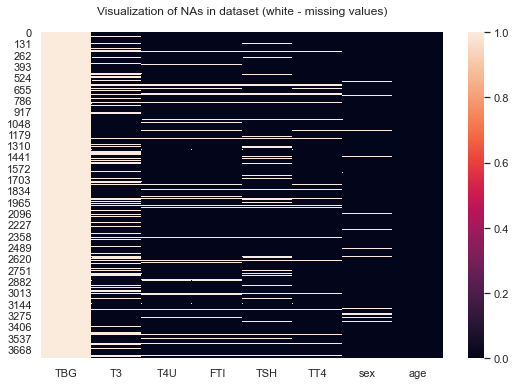

In [10]:
sns.heatmap(data[missing_data.index].isna()); # selecting only those variables which contain any missings
plt.title('Visualization of NAs in dataset (white - missing values)\n');

It looks like for some records all hormone tests results (or most of them) are missing. However when we look into it, we can see that there are no rows in our data with more than 3 missings (we don't take `TBG` into consideration).

In [11]:
data.apply(lambda x: x.count(), axis=1).sort_values(ascending=True)

685     23
2648    23
2145    23
2792    23
700     24
        ..
1471    29
1472    29
1473    29
1444    29
3771    29
Length: 3772, dtype: int64

Given all the information above, we don't really have records to drop (apart from the possible outliers) because 3 missings among 29 variables are not a reason good enough to drop them.
We will procede with deleting meaningless columns and imputing the rest of the missings.

### I.III Target analysis

In [12]:
data.Class.value_counts()

negative                   3481
compensated_hypothyroid     194
primary_hypothyroid          95
secondary_hypothyroid         2
Name: Class, dtype: int64

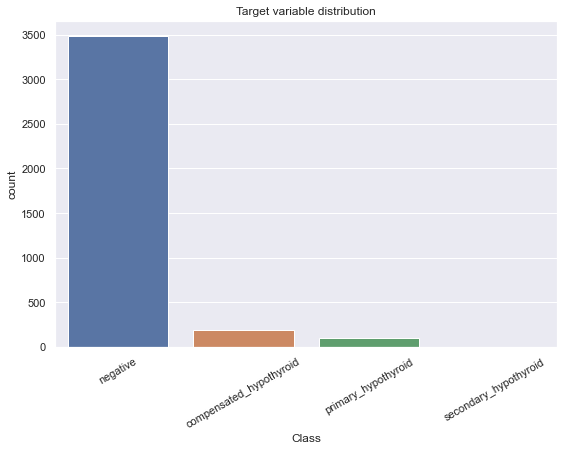

In [13]:
s = sns.countplot(data.Class)
s.set_title('Target variable distribution')
s.set_xticklabels(s.get_xticklabels(), rotation=30);

We can see that our target is highly imbalanced, and one of the classes is assigned to only two records. Let's check whether they're not outliers or missings.

In [14]:
data.query('Class=="secondary_hypothyroid"')

age sex on_thyroxine query_on_thyroxine on_antithyroid_medication sick  \
1505  41.0   M            f                  f                         f    f   
2735  46.0   F            f                  f                         f    f   

     pregnant thyroid_surgery I131_treatment query_hypothyroid  \
1505        f               f              f                 t   
2735        f               f              f                 f   

     query_hyperthyroid lithium goitre tumor hypopituitary psych TSH_measured  \
1505                  f       f      f     f             f     f            t   
2735                  f       f      f     f             f     f            t   

        TSH T3_measured   T3 TT4_measured   TT4 T4U_measured   T4U  \
1505  0.015           t  2.5            t  22.0            f   NaN   
2735  4.600           t  1.2            t  48.0            t  0.89   

     FTI_measured   FTI TBG_measured  TBG referral_source  \
1505            f   NaN            f  NaN           other   
2735            t  54.0            f  NaN           other   

                      Class  
1505  secondary_hypothyroid  
2735  secondary_hypothyroid

They don't look suspicious so we will need to deal with this very highly imbalanced class.

### I.IV Other variables - distribution, correlation & relationships

<AxesSubplot:>

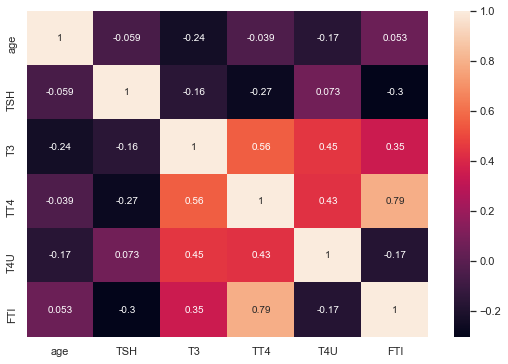

In [15]:
corr = data.drop('TBG', axis=1).corr()
sns.heatmap(corr, annot=True)

We can see one significant positive correlation - between `FTI` and `TT4` variables.

In [16]:
# temporarily deleting obvious outliers and meaningless features to have more insightful EDA
data_eda = data.query('age < 120').drop(['TBG', 'TBG_measured'], axis=1)

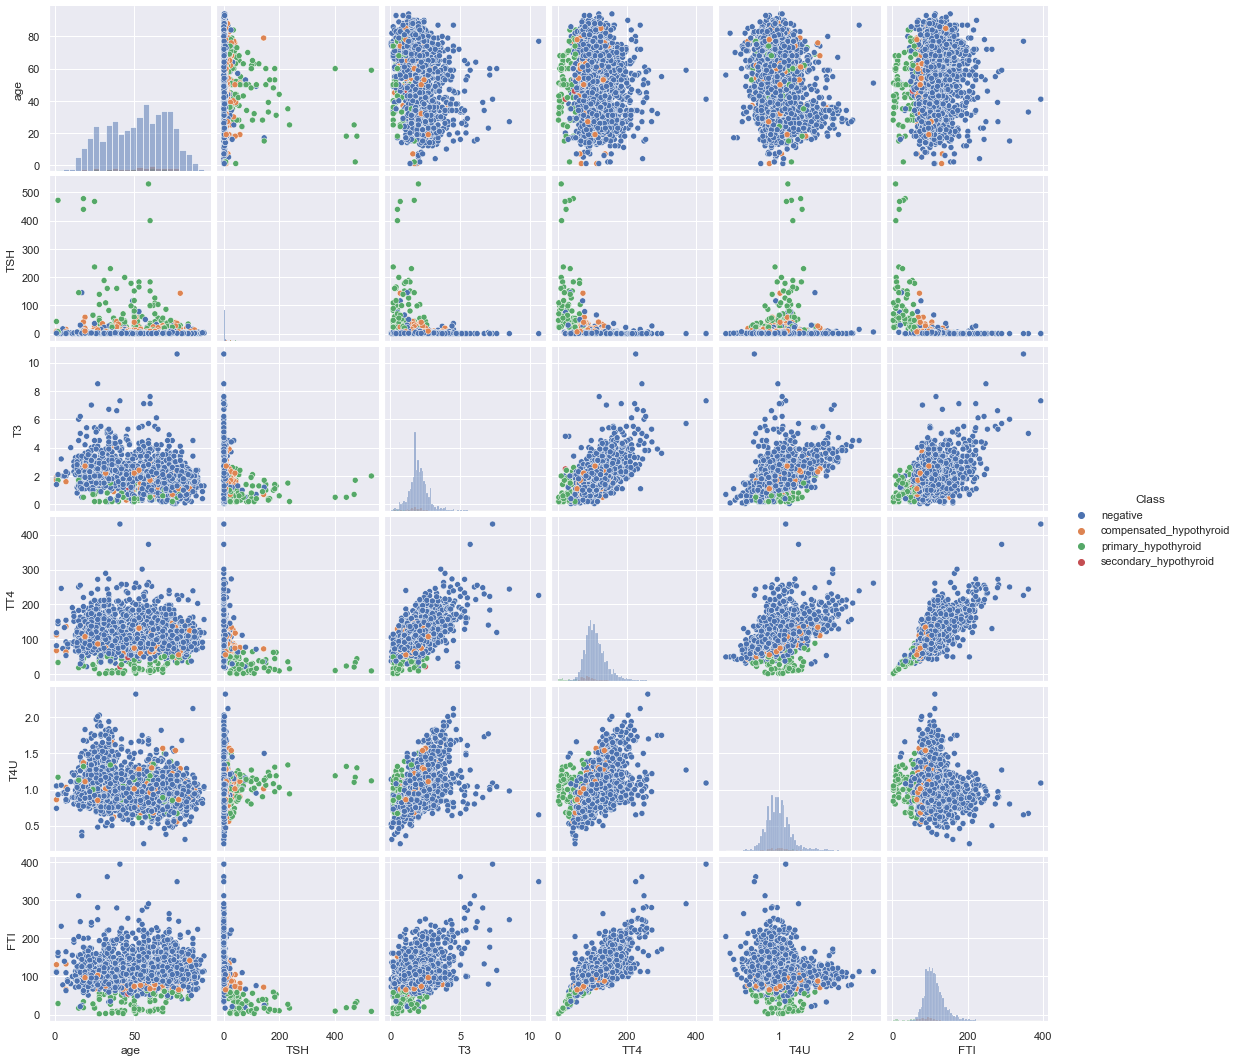

In [17]:
# numeric features distribution and relationships depending on diagnose
sns.pairplot(data_eda, hue="Class", diag_kind="hist")

We can see some interesting correlations - e.g. in case of `T3`, `FTI` and `TT4` hormones the lower the value, the more positive cases identified. As for `TSH` - completely the opposite, because the higher the value, the greater chances of sickness.

[(0.0, 450.0), Text(0.5, 1.0, 'TT4 and FTI relathionship')]

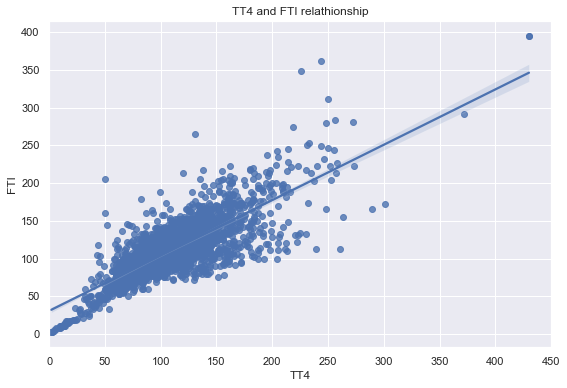

In [18]:
sns.regplot(data=data_eda, x='TT4',y="FTI").set(xlim=(0, 450), title='TT4 and FTI relathionship')

As expected based on correlation matrix, we have strong positive correlation between those variables - further investigation (the Internet) tells us it's normal because FTI is calculated based on TT4. We need to keep it in mind in case of multicollinearity between those variables.

Text(0.5, 1.0, 'Age vs sex distribution')

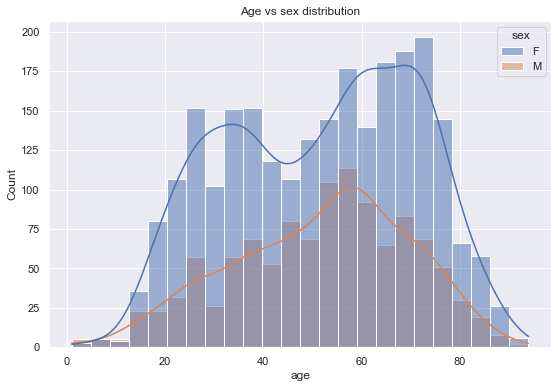

In [19]:
sns.histplot(data=data_eda, x='age', hue='sex', kde=True).set_title('Age vs sex distribution') # practically 2x more women

## II Data preprocessing

### II.I Dropping unimportant features

During EDA phase we identified two features which are useless for our model - `TBG_measured` has value `f` for all the patients and therefore `TBG` is missing, so we drop them both.

Additionally, numerical variables (containing information about hormone level) will be imputed in the next steps so columns named `x_measured` become meaningless, as we will have all the values.

In [20]:
data = data.drop(['TBG','TBG_measured','TSH_measured', 'T3_measured', 'TT4_measured','T4U_measured', 'FTI_measured'], axis=1)
data.shape

(3772, 23)

### II.II Missing values & outliers

Also from the EDA we know that we have some missing values to deal with. We will conduct following imputations:
* `sex` - impute with *Unknown* value (in my opinion better than imputing with mode or randomly)
* `age`,`TSH`,`T3`,`TT4`,`T4U`,`FTI` - median imputation (because we have little bit skewed distibutions in case of hormons)

We will combine this step in a pipeline with data normalization in the next section.

Additionally, we will change the `age` outlier identified during EDA to NaN in order to impute it with median to get rational value.

In [21]:
data.query('age > 120')['age'] = np.nan

### II.III Data normalization

We will transform the data using `StandardScaler` (all methods tried out during EDA phase gave similar results) . We will only define the pipeline here, ultimately transformation will be performed on the training and test set separately.

In [22]:
one_cols = ['referral_source', 'sex']
num_cols = data.select_dtypes('number').columns
bin_cols = data.select_dtypes(np.object).columns
bin_cols = bin_cols.drop(['referral_source', 'sex', 'Class'])
data_target = data[target]

In [23]:
target_names = list(np.unique(data_target))

In [24]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('variance_trsh', VarianceThreshold(threshold=0.1))
])

### II.IV Categorical encoding

All / Most of our `object` type variables take two values - `t (true) / f (false)` or `F (Female) / M (Male)` so we can encode them as `0 / 1` binary variables. As for the `referral_source` variable, we will use one-hot encoding because we don't know whether there's a natural order of the categories. The same encoding we will perform in case of `sex` variable.

In [25]:
data.referral_source.value_counts()

other    2201
SVI      1034
SVHC      386
STMW      112
SVHD       39
Name: referral_source, dtype: int64

In [26]:
bin_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')), # just in case, no need
    ('encoder', OrdinalEncoder()), # will work as binary
])

one_hot_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('encoder', OneHotEncoder())
])

In [27]:
pipe = ColumnTransformer(transformers=[
    ('bin', bin_pipe, bin_cols),
    ('num', num_pipe, num_cols),
    ('one', one_hot_pipe, one_cols)
])

In [28]:
temp = pipe.fit_transform(data) # just to get column names
one_hot_names = pipe.named_transformers_['one']['encoder'].get_feature_names()
for i in range(len(one_hot_names)):
    one_hot_names[i] = one_hot_names[i].replace('x0','referral_source')
    one_hot_names[i] = one_hot_names[i].replace('x1','sex')
    
column_names = bin_cols.to_list() + num_cols.to_list() + list(one_hot_names)

## III Classification task

### III.I Metrics

Due to imbalance of our data, we should consider appropriate metrics to evaluate our models. Let's go with following:
* **Recall** - due to medical nature of our dataset we don't want to miss any positives (diagnosed sickness)
* **Precision** - we want to minimize False Positives as well
* **F1 and FBeta score** - the harmonic mean of precision and recall, FBeta especially useful here, because we care about recall more, so we can give it more importance
* **Micro/weighted Average F1_Score** - takes number of instances in each class into account, therefore better for imbalanced data
* **Confusion matrix (normalized)** - useful when we have more than 2 classes, normalized due to imbalance

All the metrics above will be proper for our data, as we can calculate them for each class and take imbalance into account. 

In [29]:
def evaluate_metrics(true, pred):
    Precision = precision_score(true, pred, average = None)
    Recall = recall_score(true, pred, average = None)
    F1_score = f1_score(true, pred, average = None)
    F_beta = fbeta_score(true, pred, average = None,beta=2)
    
    results = pd.DataFrame(np.array([Precision,Recall,F1_score,F_beta]))
    results.index = ['Precision','Recall','F1_score','F_beta']
    results.columns = target_names
    f1 = f1_score(true, pred, average='weighted')
    return results, f1

In [30]:
def plot_confusion(classifier, X, y, name):
    plot_confusion_matrix(classifier, X, y, normalize='true', cmap=plt.cm.Blues, xticks_rotation = '30')
    plt.grid(False)
    plt.title(name + ' confusion matrix', size=16)
    plt.xlabel = 'Predicted label'
    plt.ylabel = 'True label'

### III.II Cross-validation

We will use a version of k-fold cross-validation that preserves the imbalanced class distribution in each fold. It is called stratified k-fold cross-validation and will enforce the class distribution in each split of the data to match the distribution in the complete training dataset.

### III.III Baseline models - train/test split

In [31]:
# we need to adjust the split as well to take the imbalance into account - stratify option; 75/25 ratio
data_train, data_test, target_train, target_test = train_test_split(data, data_target, stratify=data_target, 
                                                                    test_size=0.25, random_state=1)

In [32]:
# making sure that minority class is in both datasets
print(data_target.value_counts()/len(data_target))
print(target_train.value_counts()/len(target_train))
print(target_test.value_counts()/len(target_test)) 

negative                   0.922853
compensated_hypothyroid    0.051432
primary_hypothyroid        0.025186
secondary_hypothyroid      0.000530
Name: Class, dtype: float64
negative                   0.922941
compensated_hypothyroid    0.051608
primary_hypothyroid        0.025097
secondary_hypothyroid      0.000353
Name: Class, dtype: float64
negative                   0.922587
compensated_hypothyroid    0.050901
primary_hypothyroid        0.025451
secondary_hypothyroid      0.001060
Name: Class, dtype: float64


In [33]:
X_train = pd.DataFrame(pipe.fit_transform(data_train))
X_test = pd.DataFrame(pipe.transform(data_test))

y_train = pd.Series(target_train)
y_test = pd.Series(target_test)

X_train.columns = column_names
X_test.columns = column_names

### III.III.I KNN (k-nearest neighbours)

In [34]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train)
pred = neigh.predict(X_test)

In [35]:
results, f1 = evaluate_metrics(y_test,pred)
print(f1)
results

0.9283290588396981


compensated_hypothyroid  negative  primary_hypothyroid  \
Precision                 0.500000  0.949506             0.950000   
Recall                    0.125000  0.994253             0.791667   
F1_score                  0.200000  0.971364             0.863636   
F_beta                    0.147059  0.984969             0.818966   

           secondary_hypothyroid  
Precision                    0.0  
Recall                       0.0  
F1_score                     0.0  
F_beta                       0.0

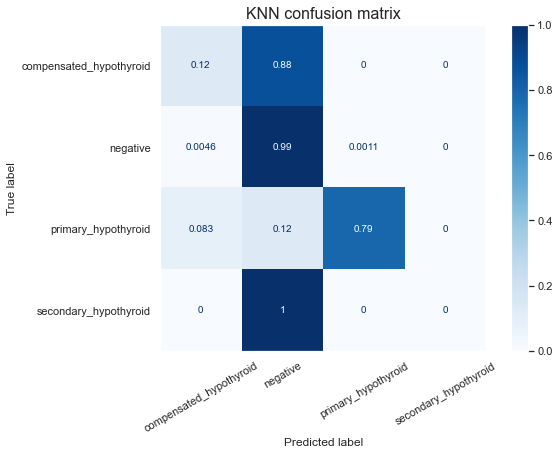

In [36]:
plot_confusion(neigh, X_test,y_test,'KNN')

KNN gives us quite good prediction for `negative` and `primary_hypothyroid` classes, however the first class is mostly wrong classified. As for the last one, it is only one record so it's hard to evaluate this prediction.

### III.III.II Logistic regression (with regularization - by default)

In [37]:
clf_reg = LogisticRegression().fit(X_train, y_train)
pred = clf_reg.predict(X_test)

In [38]:
results, f1 = evaluate_metrics(y_test,pred)
print(f1)
results

0.9441159727168532


compensated_hypothyroid  negative  primary_hypothyroid  \
Precision                 0.652174  0.962180             0.857143   
Recall                    0.312500  0.994253             0.750000   
F1_score                  0.422535  0.977954             0.800000   
F_beta                    0.348837  0.987668             0.769231   

           secondary_hypothyroid  
Precision                    0.0  
Recall                       0.0  
F1_score                     0.0  
F_beta                       0.0

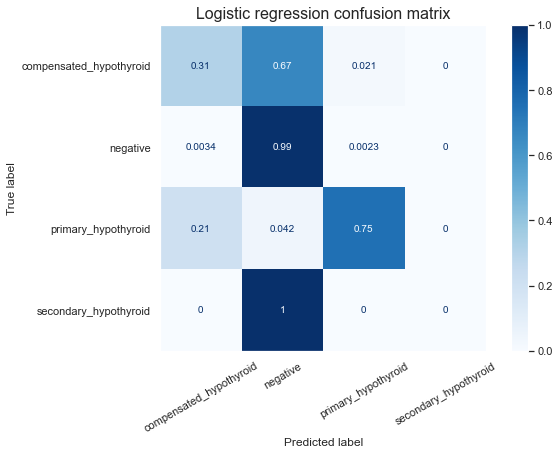

In [39]:
plot_confusion(clf_reg, X_test,y_test,'Logistic regression')

We can observe that all the metrics give 0 score for the last class, but we need to remember that it's only one record, so it means that basically this one record was classified wrongly. Generally the scores are the worse for `compensated hypothyroid` class.

### III.III.III Logistic regression (without regularization)

In [40]:
clf = LogisticRegression(penalty='none').fit(X_train, y_train)
pred = clf.predict(X_test)

In [41]:
results, f1 = evaluate_metrics(y_test,pred)
print(f1)
results

0.9590508503968879


compensated_hypothyroid  negative  primary_hypothyroid  \
Precision                 0.781250  0.974128             0.772727   
Recall                    0.520833  0.995402             0.708333   
F1_score                  0.625000  0.984650             0.739130   
F_beta                    0.558036  0.991073             0.720339   

           secondary_hypothyroid  
Precision                    0.0  
Recall                       0.0  
F1_score                     0.0  
F_beta                       0.0

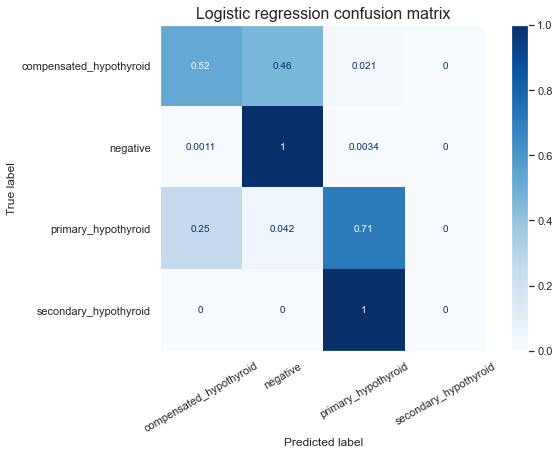

In [42]:
plot_confusion(clf, X_test, y_test,'Logistic regression')

We can see that without regularization our results are better, especially for `compensated hypothyroid`, for `primary` a bit lower, and `secondary_hypothyroid` is better classified (not properly, but as hypothyroid, not negative case).

### III.IV Feature importance

LogisticRegression classifier returns a coef_ array in the shape of (n_classes, n_features) in the multiclass case. These coefficients map the importance of the feature to the prediction of the probability of a specific class. We will analyse them separately, because given feature may be more informative for some classes than others.

* class 0 - compensated hypothyroid
* class 1 - negative
* class 2 - primary hypothyroid
* class 3 - secondary hypothyroid

In [43]:
def plot_importance_logreg(model, colnames, i, ax):
    importance = pd.DataFrame({'Weight': np.abs(model.coef_[i]),'Variable': colnames})
    imp = importance.sort_values(by='Weight', ascending=False)
    plot = sns.barplot( x='Weight',y='Variable', data=imp, ax=ax)
    plot.set_title('Feature importance for '+str(i)+ ' class', size=14)
    plot.set(ylabel='', xlabel='')
    if i == 2 | i==3: plot.set(xlabel='Weight')

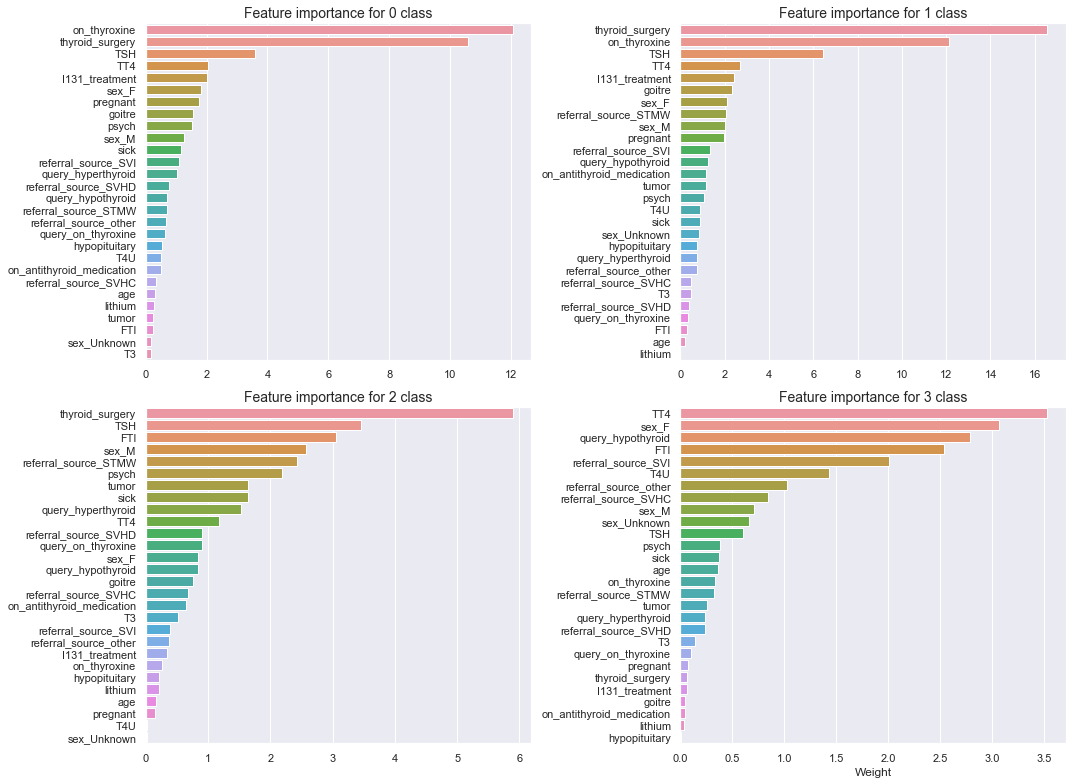

In [44]:
# analysis for LogisticRegression without regularization
fig, axes = plt.subplots(2,2,figsize=(15,11))
for i in range(len(target_names)):
    plot_importance_logreg(clf, column_names, i, axes[i//2,i%2])
plt.tight_layout()

We can see that there are some features not really important for every class - `lithium`, `hypopituitary`. Let's drop them and see whether it will better our performance.

In [45]:
X_train2 = X_train.drop(['lithium','hypopituitary'], axis=1)
X_test2 = X_test.drop(['lithium','hypopituitary'], axis=1)

In [46]:
clf = LogisticRegression(penalty='none').fit(X_train2, y_train)
pred = clf.predict(X_test2)

In [47]:
results, f1 = evaluate_metrics(y_test,pred)
print(f1)
results

0.9590508503968879


compensated_hypothyroid  negative  primary_hypothyroid  \
Precision                 0.781250  0.974128             0.772727   
Recall                    0.520833  0.995402             0.708333   
F1_score                  0.625000  0.984650             0.739130   
F_beta                    0.558036  0.991073             0.720339   

           secondary_hypothyroid  
Precision                    0.0  
Recall                       0.0  
F1_score                     0.0  
F_beta                       0.0

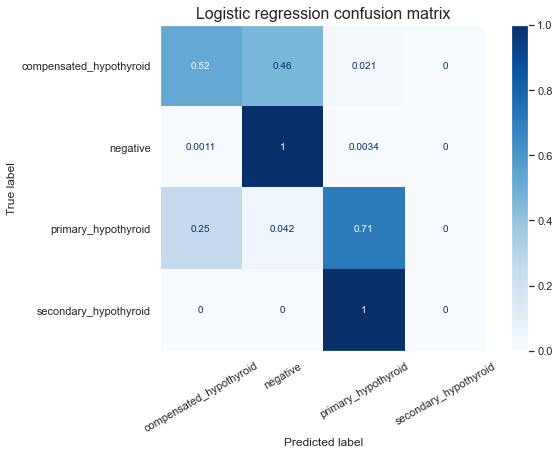

In [48]:
plot_confusion(clf, X_test2, y_test,'Logistic regression')

Results are similar to the ones before - there's no visible improvement. Let's try another approach.

### III.V Hyperparameters tuning

Earlier no regularization showed us better results, but maybe with different parameters it will be more satysfying.

In [49]:
# stratified K-fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1) 

# model
model = Pipeline([('preprocessor', pipe), 
                     ('estimator', LogisticRegression())])
# parameter grid
grid = {
    'estimator__penalty': ['l2'],
    'estimator__solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'estimator__C' : [100, 50, 10, 1.0, 0.1, 0.01]
}

gs = GridSearchCV(model, grid, 
                  n_jobs=-1,
                  scoring= 'f1_micro', 
                  refit='f1_micro', 
                  cv=skf)

gs.fit(data_train,target_train)
gs.best_params_

{'estimator__C': 100,
 'estimator__penalty': 'l2',
 'estimator__solver': 'newton-cg'}

In terms of `f1_micro` metric `l2` penalty with `newton-cg` solver and `C` equal 100 turned out to be the best set of parameters from the provided grid. Let's try them.

In [50]:
clf = LogisticRegression(penalty='l2', solver='newton-cg', C=100).fit(X_train, y_train)
pred = clf.predict(X_test)

In [51]:
results, f1 = evaluate_metrics(y_test,pred)
print(f1)
results

0.9581600962101354


compensated_hypothyroid  negative  primary_hypothyroid  \
Precision                 0.735294  0.974099             0.809524   
Recall                    0.520833  0.994253             0.708333   
F1_score                  0.609756  0.984073             0.755556   
F_beta                    0.553097  0.990156             0.726496   

           secondary_hypothyroid  
Precision                    0.0  
Recall                       0.0  
F1_score                     0.0  
F_beta                       0.0

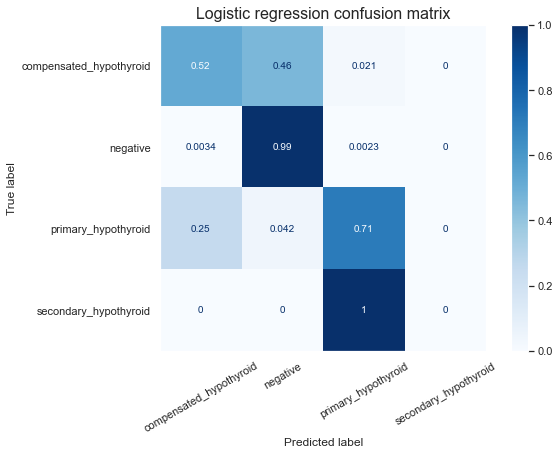

In [52]:
plot_confusion(clf, X_test, y_test,'Logistic regression')

The result isn't much better than our previous ones - classification for each class look similar. Let's now try to choose optimal value of k_neighbours in KNN algorithm.

<AxesSubplot:>

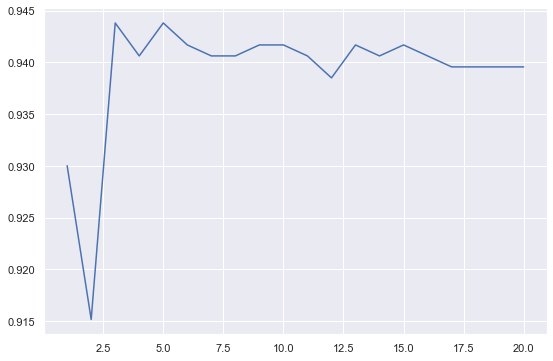

In [53]:
f1 = []
for i in range(1,21,1):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train, y_train)
    pred= neigh.predict(X_test)
    f1.append(f1_score(y_test, pred, average='micro'))
    
sns.lineplot(x=np.arange(1,21), y=f1)

We can see that k=3 or k=5 are the best among chosen range, so the one we already used.

## IV Extra work

Another way of dealing with imbalanced data is oversampling. SMOTE is a technique to oversample the minority class, which generates linear combinations of existing samples to balance the data.

In [54]:
#we need to adjust the split as well to take the imbalance into account - stratify option; 75/25 ratio
data_train, data_test, target_train, target_test = train_test_split(data, data_target, stratify=data_target, 
                                                                    test_size=0.25, random_state=123)

In [55]:
# minority class isn't in the test data, otherwise we couldn't perform SMOTE (doesn't work with only one record of given class)
print(target_test.value_counts()/len(target_test)) 

negative                   0.922587
compensated_hypothyroid    0.051962
primary_hypothyroid        0.025451
Name: Class, dtype: float64


In [56]:
X_train_ = pd.DataFrame(pipe.fit_transform(data_train))
X_test = pd.DataFrame(pipe.transform(data_test))
X_train.columns = column_names
y_train = pd.Series(target_train)
y_test = pd.Series(target_test)

In [57]:
oversample = SMOTE(k_neighbors=1) # we can only set k=1 because one of the classes has only 2 observations
X, y = oversample.fit_resample(X_train, y_train)

In [58]:
y.value_counts() # we can see that know all of our classes have the same number of instances

negative                   2611
secondary_hypothyroid      2611
primary_hypothyroid        2611
compensated_hypothyroid    2611
Name: Class, dtype: int64

In [59]:
fig = px.scatter_3d(X, x='TT4',z='T3',y='FTI', color=y)

fig.update_traces(marker=dict(size=5,
                              line=dict(width=0.5,
                                        color='white')),
                  selector=dict(mode='markers'))
fig.show()

Default view is not very informative, after moving it differently we can see the data a little bit better. We can also see it quite good on the 2d plot.

Text(0.5, 1.0, 'Distribution of new sample')

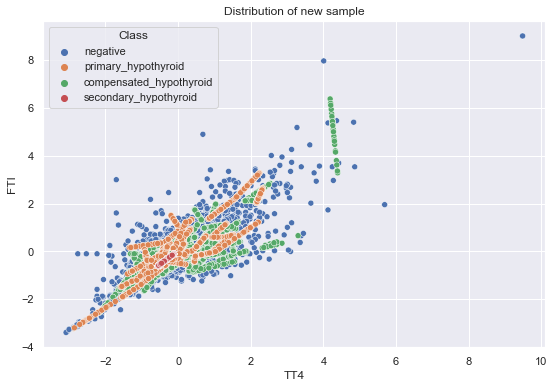

In [60]:
sns.scatterplot(x=X.TT4, y=X.FTI, hue=y).set_title('Distribution of new sample')

Let's see how our baseline model will perform on the new sample.

In [61]:
clf = LogisticRegression().fit(X, y)
pred  = clf.predict(X_test)

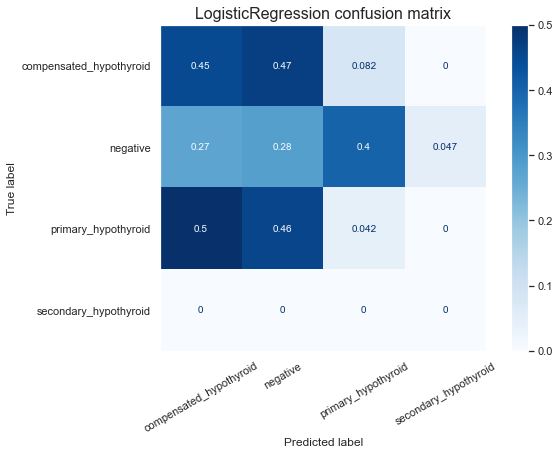

In [62]:
plot_confusion(clf, X_test, y_test, 'LogisticRegression')

We can see that default LogisticRegression doesn't perform well on such data. Let's try KNN.

In [63]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train)
pred = neigh.predict(X_test)

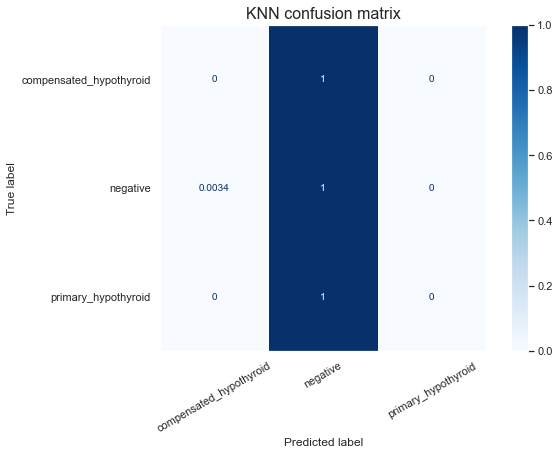

In [64]:
plot_confusion(neigh, X_test, y_test, 'KNN')

It looks even worse, because all of our data is classified as negative. So let's maybe try another model instead of oversampling.

In [ ]:
svm = SVC(kernel='linear', C=100)
svm.fit(X_train,y_train)
pred = svm.predict(X_test)
f1_score(y_test, pred, average='weighted')

In [ ]:
plot_confusion(svm, X_test, y_test, 'SVM')

We can see that SVM gives us the best result so far, definitely better in case of `compensated_hypothyroid`. Let's try grid search to improve it.

In [ ]:
# stratified K-fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1) 

# model
model = Pipeline([('preprocessor', pipe), 
                     ('estimator', SVC(class_weight='balanced'))])
# parameter grid
grid = {
    'estimator__kernel': ['linear', 'poly', 'sigmoid', 'rbf'],
    'estimator__C' : [500, 200, 100, 50, 10, 1.0, 0.1, 0.01]
}

gs = GridSearchCV(model, grid, 
                  n_jobs=-1,
                  scoring= 'f1_micro', 
                  refit='f1_micro', 
                  cv=skf)

gs.fit(data_train,target_train)
gs.best_params_

In [ ]:
svm = SVC(kernel='linear', C=500)
svm.fit(X_train,y_train)
pred = svm.predict(X_test)
f1_score(y_test, pred, average='weighted')

In [ ]:
plot_confusion(svm, X_test, y_test, 'SVM')

It is definitely our best result so far, SVM performs a lot better than previously considered algorithms.